# Ансамбли моделей машинного обучения.
***
## 1. Описание задания.
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

## 2. Выполнение работы.

#### Задание 1

Выберем датасет для выполения лабораторной работы. В данном датасете рассматриваются параметры вин, выращенных на разных винодельнях в одном регионе Италии.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import *

wine = load_wine()
pd_wine = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

#### Задание 2

In [2]:
pd_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [3]:
pd_wine.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

В данном датасете нет пропусков и категориальных признаков, поэтому приступаем к построению моделей.

Рассмотрим корреляцию признаков в датасете.

<AxesSubplot:>

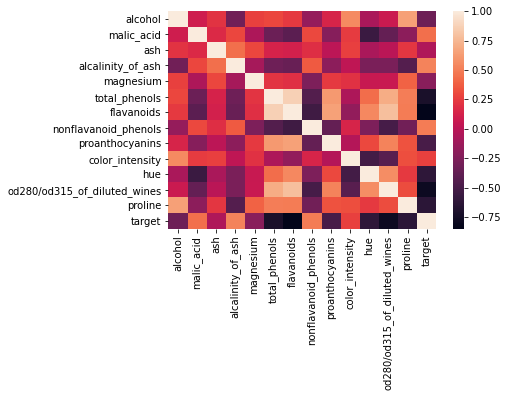

In [9]:
import seaborn as sns

sns.heatmap(pd_wine.corr())

Многие признаки сильно коррелируют с целевыми признаком (в данном случае 3 винодельни), что позволит нам решить задачу классификации.

#### Задание 3

Используем метод train_test_split для получения обучающей и тестовой выборок.

In [7]:
from sklearn.model_selection import train_test_split
wine_X_train, wine_X_test, wine_Y_train, wine_Y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=1)

#### Задание 4

Построим и оценим ансамблевые модели.

##### 1) Случайный лес

Данный метод использует как технологию бутстреп, так и метод случайных подпространств.

In [78]:
from sklearn.ensemble import RandomForestClassifier

tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
tree1.fit(wine_X_train, wine_Y_train)

/Users/vladislavalpeev/Documents/labs/Labs_TML/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/vladislavalpeev/Documents/labs/Labs_TML/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)

Просмотрим количество данных не попавших в выборку бутстрэпа в процентах.

In [79]:
round((1-tree1.oob_score_)*100,2)

16.94

Используем модель для пердсказания.

In [80]:
target1 = tree1.predict(wine_X_test)

Оценим полученную модель используя метрику Матрица ошибок.

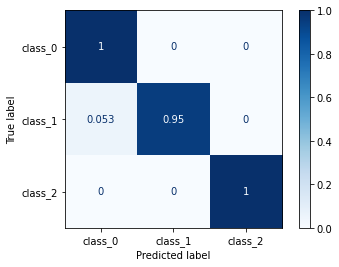

In [81]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree1, wine_X_test, wine_Y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true')

##### 2)  Градиентный бустинг

Данный метод так же предполагает последовательное многократное обучение модели с целью устранения ошибок обученных на предыдуших этапах моделей. Основным методом здесь является градиентный спуск.

Решим задачу классификации для имеющихся данных.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

cl_gb = GradientBoostingClassifier(random_state=1)
cl_gb.fit(wine_X_train, wine_Y_train)

GradientBoostingClassifier(random_state=1)

Мы можем рассмотреть какие признаки повлияли на модель больше всего.

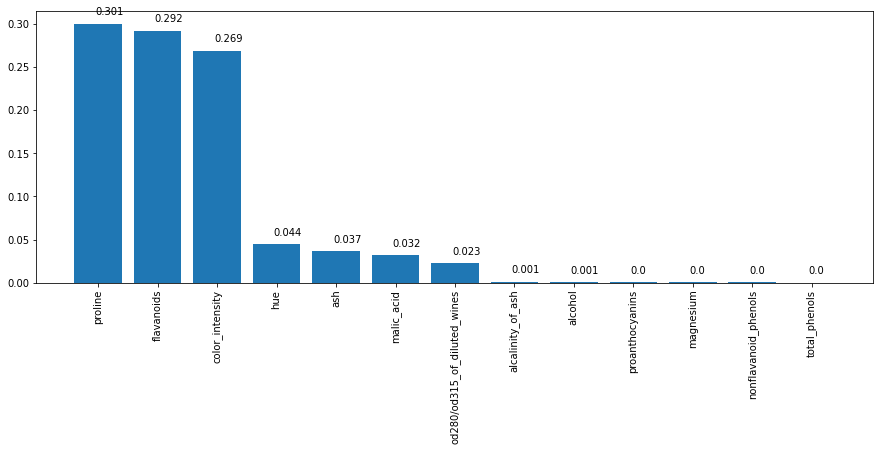

In [97]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,5)):
    
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

_,_ = draw_feature_importances(cl_gb, pd_wine)

Можем оценить графическое представление построенного дерева на двух наиболее важных признаках.

In [98]:
def make_meshgrid(x, y, h=.02):

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(wine_X, wine_Y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = wine_X[:, 0], wine_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=wine_Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('proline')
    ax.set_ylabel('flavanoids')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

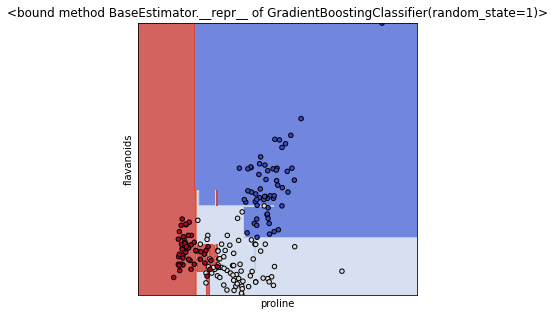

In [129]:
wine_X = wine.data[:,[6, 12]]
wine_Y = wine.target
plot_cl(GradientBoostingClassifier(random_state=1))

In [106]:
wine.data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

Оценим качество модели по выбранным метрикам.

Матрица ошибок

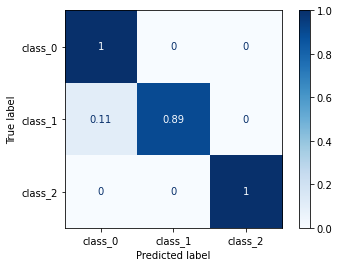

In [130]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(cl_gb, wine_X_test, wine_Y_test, 
                      display_labels=wine.target_names, 
                      cmap=plt.cm.Blues, normalize='true')

#### Вывод

По матрице ошибок можем видеть, что модель построенная на алгоритме Случайный лес делает в два раза меньше ошибок чем Градиентный бустинг.